# Explication du projet

Dans un précédent projet, une classification automatique des produits de la plateforme de Place de marché a été mise en place, et a permis d’assigner chaque produit à une catégorie de manière automatique. Cette première approche reposait sur l’utilisation du modèle VGG16, un réseau de neurones convolutifs, qui a servi de base pour établir une première solution et qui a permis de classer correctement 76% des produits de la plateforme. Le modèle pré-entraîné VGG16 a été utilisé grâce à une approche de transfert d'apprentissage pour extraire les caractéristiques visuelles des images, et l'ajout de plusieurs couches additionnelles a permis de classer les produits dans les catégories les plus probables. 

Afin d’améliorer la méthodologie développé au cours du précédent projet et d’optimiser les performances obtenues, un nouvel algorithme, plus récent a été exploré dans le premier notebook de ce projet. Le choix du nouvel algorithme s'est porté sur le Convolutional Vision Transformer, un modèle hybride qui combine les atouts de deux approches: la convolution des réseaux de neurones convolutifs et les mécanismes d'attention issus des transformers. Les performances obtenues avec cette nouvelle approche ont été comparés à celles obtenues avec la premiere approche. L’évaluation comparative des performances des deux approches de modélisation a montré que le CvT offrait des performances supérieures à celles de VGG16, tout en étant plus rapide.

Dans le présent notebook, on s'intéressera à l'interprétation des prédictions générées par le modèle. Pour cela, on explorera deux méthodes d'explicativité: une méthode basée sur l'approche SHAP et une méthode appelée Grad-CAM. Ces méthodes permettront de mieux comprendre les zones de l'image utilisées par le modèle pour prendre ses décisions. 

# Sommaire
- [1 Explication du projet](#Explication-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-bibliothèques)
- [4 Chargement du modèle et des images](#Chargement-du-modèle-et-des-images)
- [5 Explicativité du modèle par la méthode SHAP](#Explicativité-du-modèle-par-la-méthode-SHAP)
- [6 Explicativité du modèle avec la méthode Grad - Cam](#Explicativité-du-modèle-avec-la-méthode-Grad---Cam)
- [7 Conclusions](#Conclusions)

# Import des bibliothèques

In [1]:
# Librairies standard
# ----------------------------
import os
import random
import warnings

# Manipulation de données
# ----------------------------
import numpy as np
import pandas as pd

# Visualisation
# ----------------------------
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from IPython.display import display, HTML

# Suppression du warning Tqdm
# ----------------------------
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

# PyTorch
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers
# ----------------------------
from transformers import CvtForImageClassification

# Interprétabilité / Explicabilité
# ----------------------------
import shap

# Chargement du modèle et des images 

Avant de commcer à interpréter les résultats de prédictions le modèle sera rechargé à partir des poids sauvegardés lors de la phase d'apprentissage afin d'assurer que les prédictions analysées correspondent bien au modèle entrainé initialement. Pour cela, il faut réutiliser la fonction de construction du modèle puis initialiser l'architecture du modèle avant de charger les poids enregistrés. Les images seront également chargées et soummises au même traitement mis en place précédemment.

In [2]:
def create_model_CVT(num_classes=7, dense_size=256, dropout=0.5, learning_rate=1e-3, freeze_backbone=True, device=None, verbose=True):
    """
    Crée un modèle CvT pour classification avec head personnalisée et renvoie aussi les transformations 
    de data augmentation pour l'entraînement et la validation.
    
    Sortie:
        model: modèle PyTorch
        optimizer: optimiseur Adam
        criterion: CrossEntropyLoss
        device: device utilisé
        train_transform: transformations pour data augmentation train
        val_transform: transformations pour validation
    """
    
    # Configuration du periphérique selon la disponibilité d'un GPU ou non
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    # -------------------------
    # Data augmentation
    # -------------------------
    
    # Définition des transformations appliquées au jeu d'entrainement
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.9, 1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Définition des transformations appliquées au jeu de validation
    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # -------------------------
    # Modèle CvT
    # -------------------------
    
    # Chargement du modèle CvT pré entrainé
    model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
    
    # Gel des poids déjà appris
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Extraction du nombre de neurones en entrée de la couche de classification
    in_features = model.classifier.in_features
    
    # Adaptation du modèle à la tache de classification des produits
    model.classifier = nn.Sequential(
        nn.Linear(in_features, dense_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(dense_size, num_classes)
    )
    
    # Déplacement du modèle sur le périphérique selectionné
    model = model.to(device)
    
    # -------------------------
    # Optimiseur et loss
    # -------------------------
    
    # Configuration de l'optimiseur
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Configuration du critère d'optimisation
    criterion = nn.CrossEntropyLoss()
    
    return model, optimizer, criterion, device, train_transform, val_transform



In [3]:
# Date d'execution du code de modélisation
date_str = "2025-09-24_23-15-58"

# Configuration du periphérique selon la disponibilité d'un GPU ou non
device = "cuda" if torch.cuda.is_available() else "cpu"

# Chemin de sauvegarde du meilleur modèle
Save_path_best_model = f"../Models/CVT/model_CVT_best_weights_{date_str}.pth"

# Initialisation du modèle
model, optimizer, criterion, device, train_transform, val_transform = create_model_CVT(device=device, verbose=False)

# Chargement du meilleur modèle CVT
model.load_state_dict(torch.load(Save_path_best_model, map_location=device))

# Chargement des images
test_dataset = ImageFolder("../Data/Image_test/", transform=val_transform)
train_dataset = ImageFolder("../Data/Image_train/", transform=train_transform)

In [4]:
# Définition du dictionnaire classe encodée - nom de catégorie
mapping_class = {0: "Baby care", 1: "Beauty and personnal care", 2: "Computer", 3:"Home decor & Festive needs", 
                 4:"Home Furnishing", 5: "Kitchen and dining", 6: "Watches"}

# Explicativité du modèle par la méthode SHAP

L'analyse SHAP repose sur la théorie des jeux de Shapley, où chaque variable est vue comme un joueur dans un jeu coopératif qui contribue à un "gain" (la prédiction du modèle). SHAP attribue à chaque variable une importance en évaluant toutes les combinaisons possibles de variables pour déterminer leur contribution à la prédiction. Cette analyse permet de comprendre l’impact de chaque variable d’entrée sur la prédiction d’un modèle, de manière locale (pour une observation spécifique) ou globale (pour l'ensemble du dataset). 

Ici la méthode d'interprétation qui sera utilisée correspond aux Gradient Explainer qui est une approche SHAP adaptée aux modèle basées sur les gradients comme les réseaux de neurones. L'idée est de combiner les gradients de sortie du modèle par rapport aux entrées avec une approximation de l'effet de chaque variable.

- Pour une image donnée, le GradientExplainer approxime l’effet de chaque pixel sur la sortie du modèle en calculant les gradients de la prédiction par rapport aux entrées, le long d’un chemin reliant une image de référence à l’image étudiée. Cette approche permet d’attribuer une valeur SHAP à chaque pixel, traduisant son importance dans la prédiction finale.
- Lorsque calculées sur plusieurs images, ces valeurs peuvent être combinées pour produire une interprétation globale indiquant l'importance de chaque pixel pour la prédiction d'une classe spécifique, tandis que pour une image unique, elles permettent une interprétation locale.

Cette approche permet donc de visualiser quelles zones ou caractéristiques activées par le réseau ont le plus contribué à la décision finale de classification, et fournit ainsi une carte d’importance comparable à une heatmap qui explique la prédiction du modèle de manière intuitive.

## Adaptation du modèle au format attendu par SHAP

Contraitement aux modèles PyTorch classiques, le modèle CvT qui a été développé provient de Hugginface et prend en entrée des images et retourne un objet ImageClassifierOutput qui contient plusieurs champs (logit, hidden_state...). SHAP attendant un modèle dont l'entrée est un tenser de format [B, C, H, W] et dont la sortie est un tenseur de format [B, num_classes] il sera nécessaire dans un premier temps d'utiliser un wrapper pour adapter le modèle au format attendu par SHAP.

In [5]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        # x: [B,C,H,W], doit renvoyer [B,num_classes]
        return self.model(x).logits
    

In [6]:
# Association du modèle au wrapper et au périphérique et configuration en mode evaluation
f_wrapper = ModelWrapper(model).to(device).eval()

## Configuration de l'explainer

In [7]:
# Initialisation de la liste correspondant au background
background = []
images_per_class = 30
classes_count = {i: 0 for i in range(7)}  

# Création de la liste d'images à inclure dans le background
for img, label in test_dataset:
    if classes_count[label] < images_per_class:
        background.append(img.numpy())
        classes_count[label] += 1
    if sum(classes_count.values()) >= 7 * images_per_class:
        break
    
# Ajout de la dimension batch :  [C,H,W] ->  [N,C,H,W]
background = np.stack(background, axis=0)

# Conversion des valeurs en float pour PyTorch
background = background.astype(np.float32)  

# Conversion de l'array en tenseur 
background_tensor = torch.from_numpy(background).to(device)

# Affichage du format du backround
print("format du background", background_tensor.shape)

# Initialisation de l'explainer
explainer = shap.GradientExplainer(f_wrapper, background_tensor) 

format du background torch.Size([210, 3, 224, 224])


## Analyse SHAP globale

In [8]:
# Paramètres
num_samples = 30       
num_classes = 7  

# Liste des heatmaps globales
shap_global_per_class = []

# Calcul SHAP par classe
for target_class in range(num_classes):
    print(f"\nCalcul SHAP global - Classe {target_class}")

    # Sélection des images de la classe
    batch_imgs = []
    count = 0
    for img, label in test_dataset:
        if label == target_class:
            batch_imgs.append(img.numpy())
            count += 1
        if count >= num_samples:
            break

    print(f" {len(batch_imgs)} images trouvées pour la classe {target_class}")

    # Conversion en tenseur [N,C,H,W]
    batch_imgs = np.stack(batch_imgs, axis=0).astype(np.float32)
    batch_tensor = torch.from_numpy(batch_imgs).to(device)
    print(f"  batch_tensor.shape = {batch_tensor.shape}") 

    # Valeurs SHAP : (N,H,W,num_classes)
    shap_values_batch = explainer.shap_values(batch_tensor)
    print(f"  shap_values_batch.shape = {np.array(shap_values_batch).shape}")

    # Extraction de la classe cible (N,C,H,W)
    shap_class = shap_values_batch[..., target_class]
    print(f"  shap_class.shape = {shap_class.shape}")

    # Moyenne sur le batch (H,W)
    shap_global_2d = shap_class.mean(axis=0).mean(axis=0)
    print(f"  shap_global_2d.shape = {shap_global_2d.shape}")

    shap_global_per_class.append(shap_global_2d)



Calcul SHAP global - Classe 0
 30 images trouvées pour la classe 0
  batch_tensor.shape = torch.Size([30, 3, 224, 224])
  shap_values_batch.shape = (30, 3, 224, 224, 7)
  shap_class.shape = (30, 3, 224, 224)
  shap_global_2d.shape = (224, 224)

Calcul SHAP global - Classe 1
 30 images trouvées pour la classe 1
  batch_tensor.shape = torch.Size([30, 3, 224, 224])
  shap_values_batch.shape = (30, 3, 224, 224, 7)
  shap_class.shape = (30, 3, 224, 224)
  shap_global_2d.shape = (224, 224)

Calcul SHAP global - Classe 2
 30 images trouvées pour la classe 2
  batch_tensor.shape = torch.Size([30, 3, 224, 224])
  shap_values_batch.shape = (30, 3, 224, 224, 7)
  shap_class.shape = (30, 3, 224, 224)
  shap_global_2d.shape = (224, 224)

Calcul SHAP global - Classe 3
 30 images trouvées pour la classe 3
  batch_tensor.shape = torch.Size([30, 3, 224, 224])
  shap_values_batch.shape = (30, 3, 224, 224, 7)
  shap_class.shape = (30, 3, 224, 224)
  shap_global_2d.shape = (224, 224)

Calcul SHAP global 

## Analyse SHAP locale 

Classe 0 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 0 - Shape SHAP local après moyenne: (224, 224)


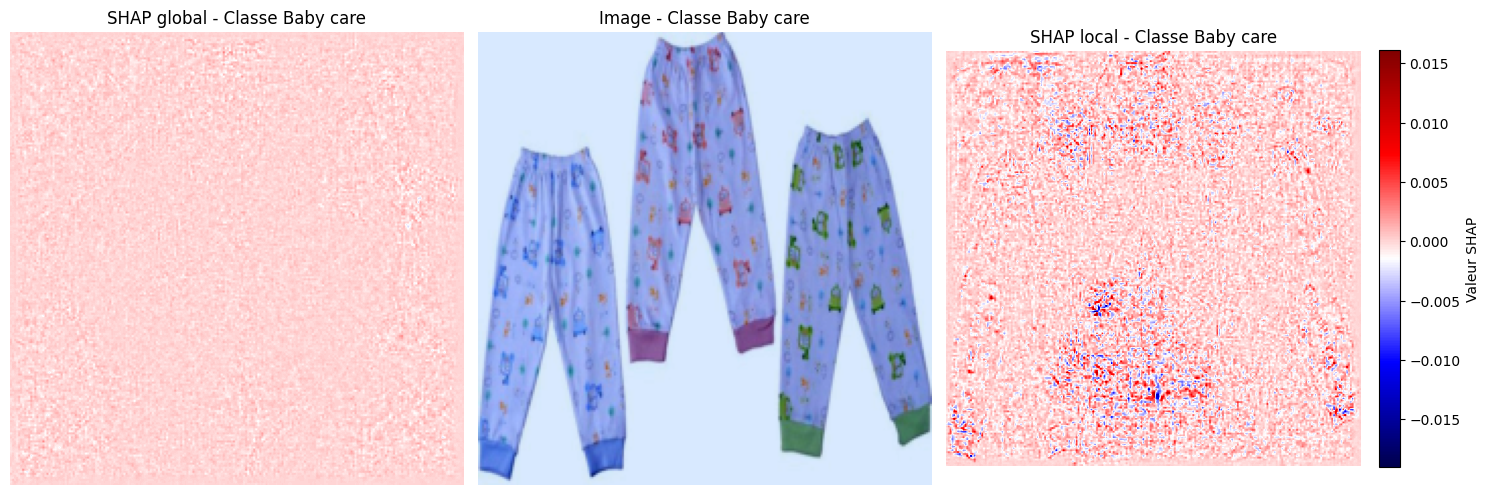

Classe 1 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 1 - Shape SHAP local après moyenne: (224, 224)


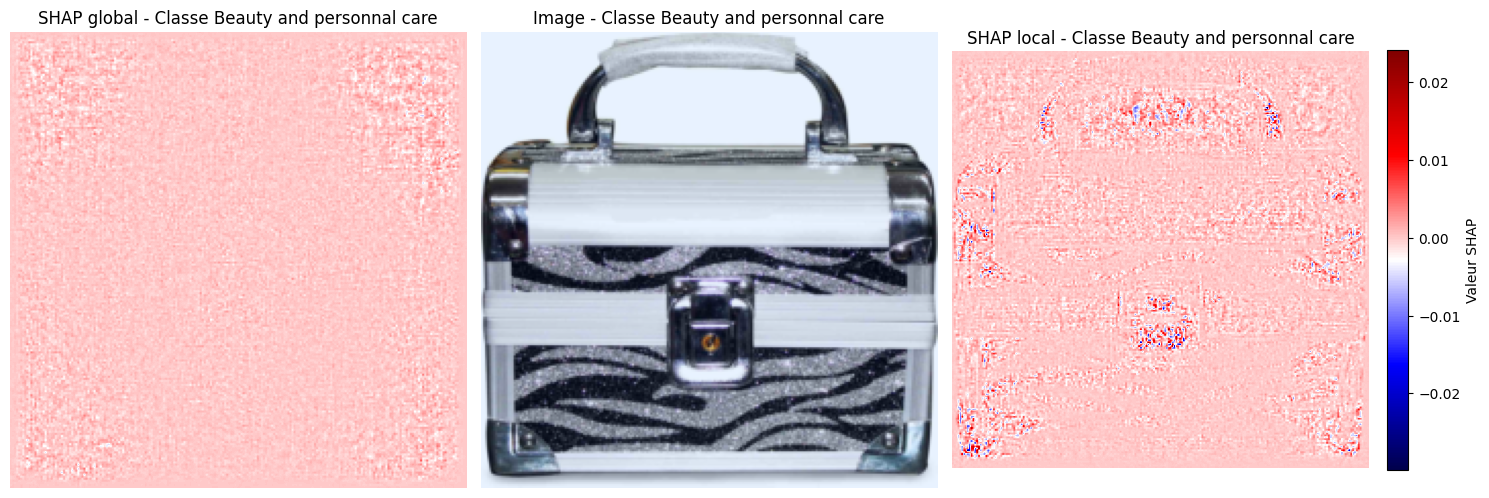

Classe 2 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 2 - Shape SHAP local après moyenne: (224, 224)


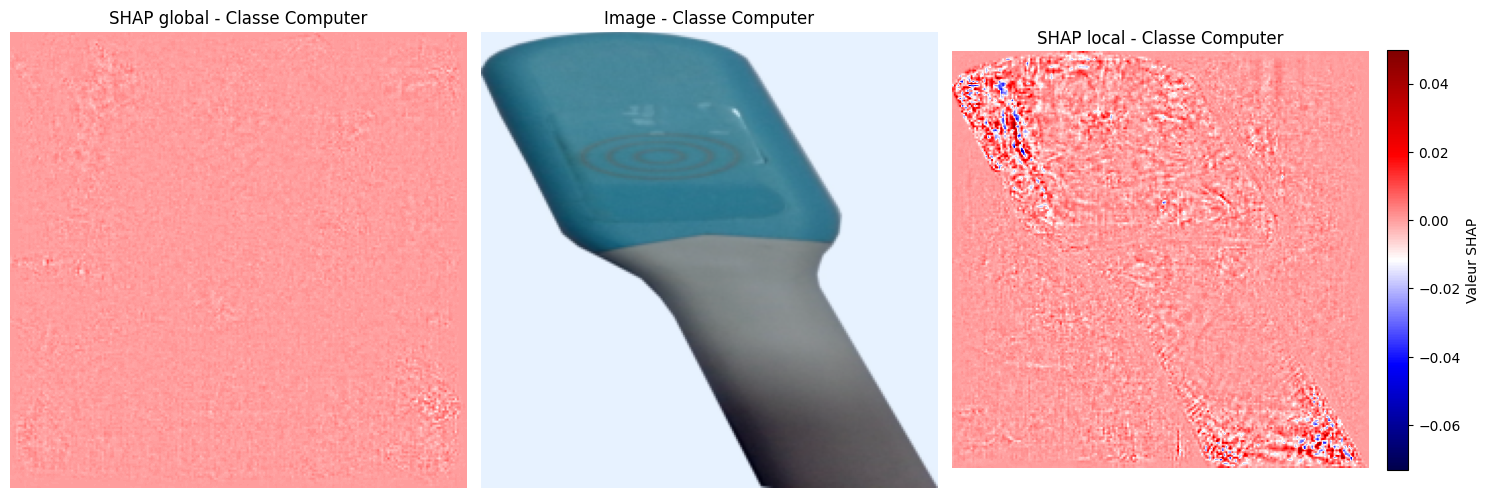

Classe 3 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 3 - Shape SHAP local après moyenne: (224, 224)


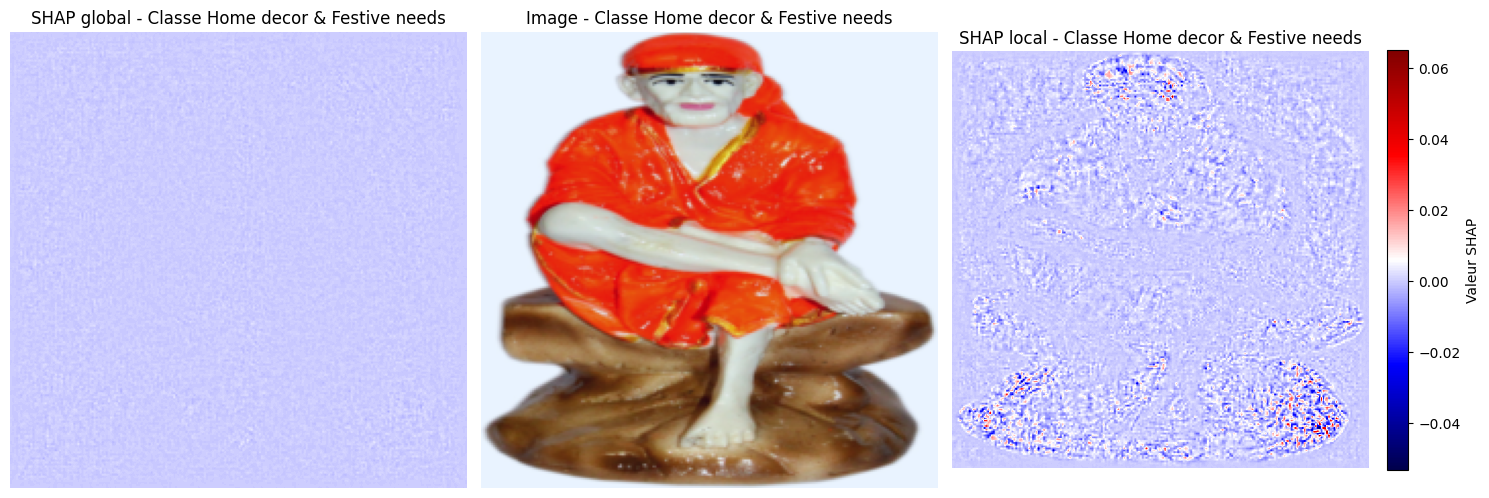

Classe 4 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 4 - Shape SHAP local après moyenne: (224, 224)


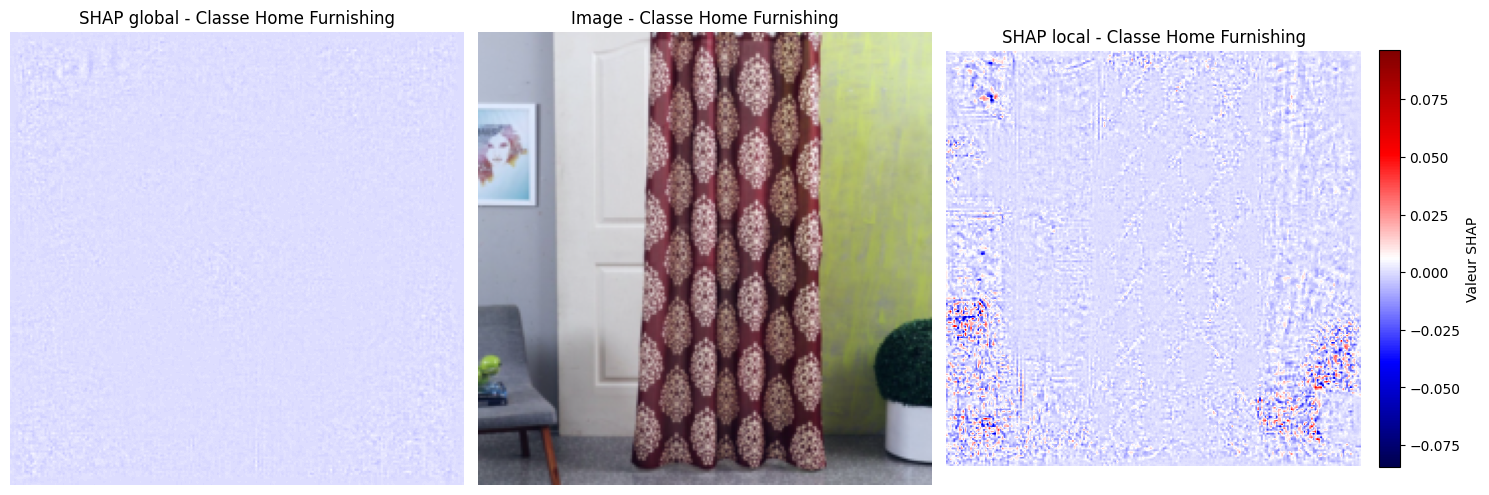

Classe 5 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 5 - Shape SHAP local après moyenne: (224, 224)


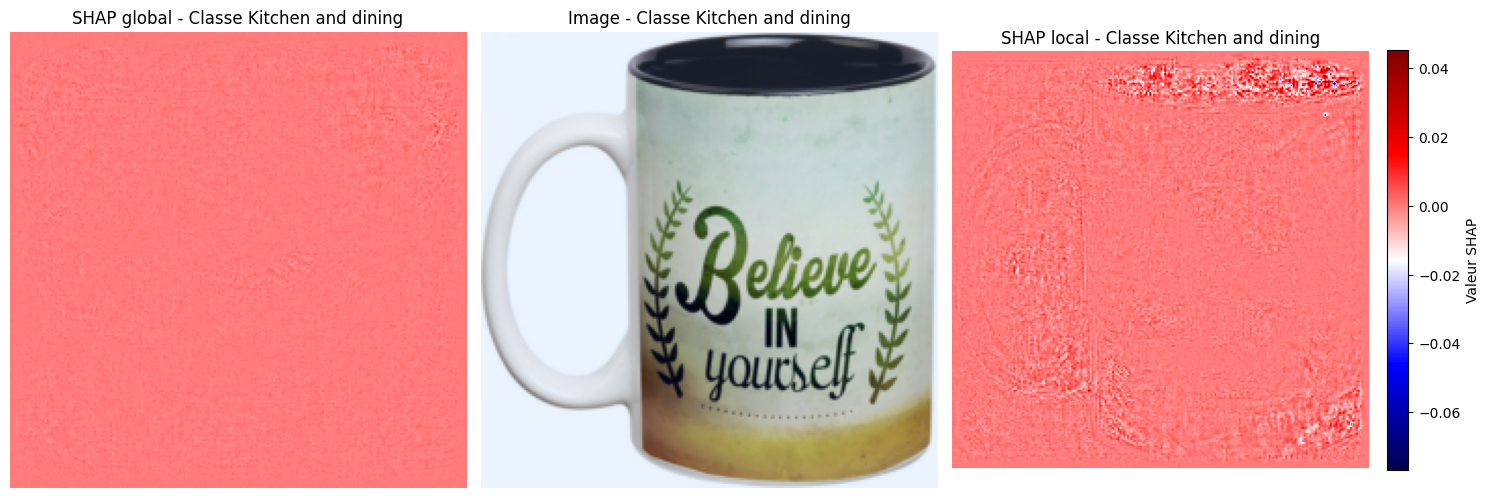

Classe 6 - Shape SHAP local avant moyenne: (3, 224, 224)
Classe 6 - Shape SHAP local après moyenne: (224, 224)


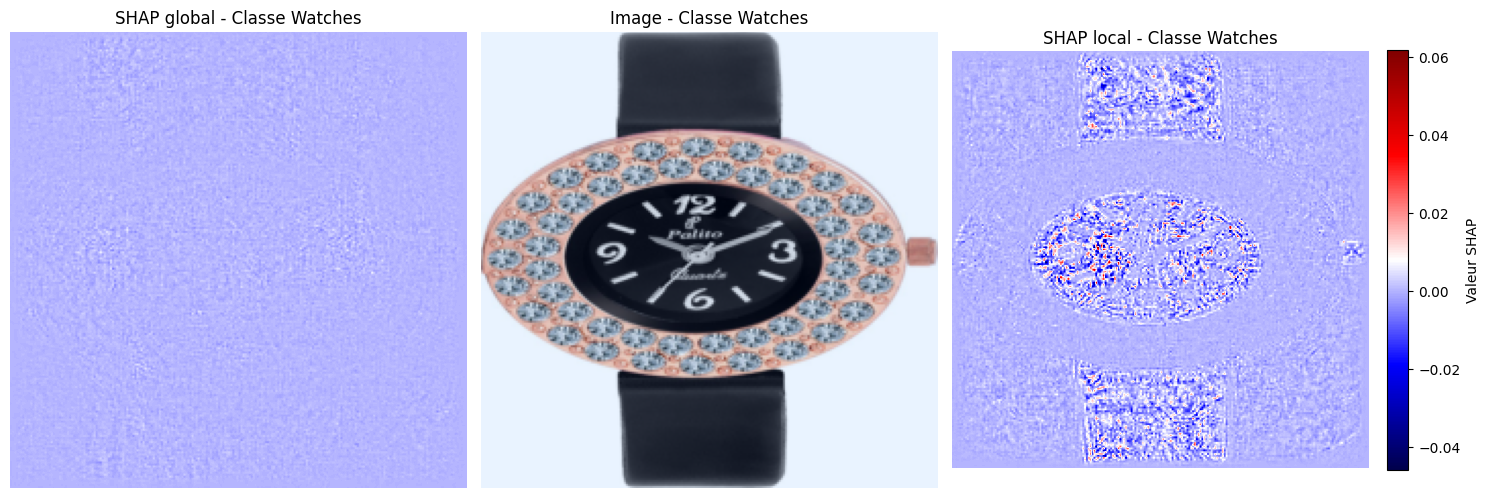

In [9]:
# Boucle sur toutes les classes pour afficher SHAP globale et locale
for target_class in range(num_classes):
    
    # Extraction du nom de la classe
    class_name = mapping_class.get(target_class, f"Classe {target_class}")

    # Extraction des valeurs shap globale de la classe
    shap_global_2d = shap_global_per_class[target_class]

    # Récupération d'une image de test de la classe en cours
    img = None
    for im, label in test_dataset:
        if label == target_class:
            img = im
            break

    # Ajout de la dimension batch
    img_batch = img.unsqueeze(0).to(device)

    # Calcul des valeurs SHAP locales pour cette image
    shap_values = explainer.shap_values(img_batch)
    heat_local = shap_values[..., target_class][0]  # (1,C,H,W)
    print(f"Classe {target_class} - Shape SHAP local avant moyenne: {heat_local.shape}")
    
    # Moyenne sur les cannaux pour obtenir une map 2D
    heat_local = heat_local.mean(axis=0) 
    print(f"Classe {target_class} - Shape SHAP local après moyenne: {heat_local.shape}")

    # Détermination des bornes min et max pour l'affichage
    vmin = min(shap_global_2d.min(), heat_local.min())
    vmax = max(shap_global_2d.max(), heat_local.max())
       
    # Création du subplot : global + image brute + shap local
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # SHAP global
    plot1 = axes[0].imshow(shap_global_2d, cmap='seismic', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"SHAP global - Classe {class_name}")
    axes[0].axis('off')

    # Image brute
    img_disp = img.permute(1,2,0).numpy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
    axes[1].imshow(img_disp)
    axes[1].set_title(f"Image - Classe {class_name}")
    axes[1].axis('off')

    # SHAP local
    plot3 = axes[2].imshow(heat_local, cmap='seismic', vmin=vmin, vmax=vmax)
    axes[2].set_title(f"SHAP local - Classe {class_name}")
    axes[2].axis('off')
    
    # Ajout d'une barre de couleur 
    cbar = fig.colorbar(plot3, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label("Valeur SHAP", fontsize=10)

    # Ajustement de la figure
    plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Explicativité/SHAP.png', format='png')

    # Affichage de la figure
    plt.show()


L’analyse de l'interprétabilité du modèle avec SHAP Gradient Explainer a abouti a des résultats difficilement interprétable. Les cartes d'importances globales apparaissent homogènes avec très peu de variation entre les différents pixels. Au niveau local, il semble qu'il y ait pour certaines images, des pixels avec des importances plus importantes que d'autres mais en réalité les différences restrent très faibles avec des valeurs d'importances très proches comprise dans des intervalles restreints.

Ces observations traduisent les limites de cette approche pour l'analyse de l'interprétatibilité des modèles de classification appliqués sur des images. En effet, ici SHAP analyse les contributions au niveau des pixels alors qu'un pixel isolé n'a pas de signification particulière. Chaque pixel contribut finalement très peu aux prédictions finales ce qui explique pourquoi les valeurs shap se retrouvent très proches les unes des autres. De plus les pixels voisins sont souvent fortement corrélés ce qui rend les contributions instables et bruités. La limite de l'approche SHAP pour l'explicativité des modèles basés sur des réseau de neurones réside donc dans l'existence d'un décalage entre le niveau de l'explication et celui de l'apprentissage. En effet un réseau convolutionnel tel que le modèle CvT ne raisonne pas directement sur les pixels pour prendre ses décisions mais sur des représentations plus complexes construites au fil des couches. L'explication pixel par pixel ne reflète donc pas réellement la logique du modèle.

Pour l’analyse de l'explicativité de ce type de modèle il serait donc plus pertinent de s'orienter vers des méthodes mieux adaptées comme Grad-CAM qui mettent en évidence les zones de l’image activées par les couches convolutionnelles et permettent d’identifier les régions réellement utilisées par le modèle et dont le fonctionnement se rapproche davantage de la manière dont les réseaux convolutionnels traitent l’information, en considérant des structures ou des régions plutôt que des pixels isolés, ce qui fournit des explications plus pertinentes et interprétables. .

# Explicativité du modèle avec la méthode Grad - Cam

La méthode Gradient-weight Class Activation (Grad-CAM) est une autre méthode d'interprétation visuelle des résultats de prédiction de modèle à base de réseau de neurone convolutif et peut s'utiliser également dans le cadre du CvT. Elle permet de visualiser quelles régions de l'image ont le plus contribué à la prédiction d'une classe spécifique. Les résultats seront visualisés à l'aide d'une heatmap qui mettra en évidence les zones importantes pour la décision du modèle.

Le principe de Grad-CAM s'appuie également sur les gradients de sortie du modèle mais cette fois en considérant les cartes d'activation d'une couche convolutive et non les pixels d'entrée. 

- L'idée sera de récupérer les activations d'une couche convolutive du modèle pour l'image que l'on souhaite analyser. 
- Les gradients de la probabilité de la classe d'intéret seront ensuite calculé par rapport a chaque carte de caractéristique. Ces gradients indiquent l'importance de chaque carte pour la prédiction 
- Chaque carte est ensuite pondérée par la moyenne de ses gradients ce qui donne un poids indiquant son importance pour la classe. 
- Enfin les cartes de caractéristiques sont ensuite sommée avec la pondération et une fonction Relu est appliqué pour ne garder que les activations qui contribuent positivement a la classe prédites.

Cet algorithme peut être appliqué à différents niveaux de la structure du réseau. Lorsqu'il est appliqué aux couches proche de l'entrée, il fournira des informations plus générales et capturera des motifs larges ou des zones globales de l'image mais fournira des informations plus fines liées a des détails spécifiques de l'image analysée si appliqué a des couches plus profondes. Il est également possible de combiner cette analyse sur différents niveau pour obtenir une visualisation plus riche en intégrant des informations à la fois globales et précises.

In [10]:
def grad_cam_cvt(model, img, stages=[0,1,2], device='cuda'):
    
    """
    Calcul du Grad-CAM pour un modèle Convolutional Vision Transformer (CvT).

    Cette fonction génère une carte de chaleur (heatmap) Grad-CAM en 
    enregistrant un hook sur les couches de patch embeddings convolutionnels 
    des stages spécifiés, en effectuant un passage forward et backward, et en 
    agrégeant les cartes d'activation de classe obtenues.

    Paramètres
        - model (torch.nn.Module): Le modèle CvT à analyser.
        - img (torch.Tensor): L'image d'entrée sous forme de tenseur. 
        - stages (list of int): Liste des indices de stages sur lesquels calculer le Grad-CAM. 
          Chaque stage correspond à un ensemble de patch embeddings convolutionnels dans l'encodeur CvT.
        - device (str, par défaut cuda): Le périphérique sur lequel effectuer les calculs.

    Sortie
        - cam_combined (np.ndarray): Carte Grad-CAM agrégée et normalisée entre 0 et 1.
        - pred_class (int): La classe prédite de l'image d'entrée.
    """
    
    # Passage du modèle en mode évaluation
    model.eval()
    
    # Déplacement du modèle sur le périphérique
    model.to(device)
    
    # Ajout de la dimension batch
    img = img.unsqueeze(0).to(device)
    
    # Initialisation de la liste de résultats
    cams = []
    
    # Pour chaque stage
    for stage_idx in stages : 

        # Initialisation de la variable activations
        activations = None

        # Hook sur le patch embedding conv pour capturer les activations de la couche pendant le passage forward
        def forward_hook(module, input, output):
            nonlocal activations
            activations = output  
            activations.requires_grad_(True)

        # Appel de la fonction sur le conv embedding du stage demandé
        handle = model.cvt.encoder.stages[stage_idx].embedding.convolution_embeddings.register_forward_hook(forward_hook)

        # Passage forward : prédiction classique
        output = model(img)
        pred_class = output.logits.argmax(dim=1).item()
        target_class = pred_class

        # Passage backward : calcul du gradient de la probabilité de la classe cible par rapport aux activations capturées
        model.zero_grad()
        loss = output.logits[0, target_class]
        loss.backward(retain_graph=True)

        # Grad-CAM
        grad = activations.grad[0]  # [C,H,W]
        act  = activations[0]       # [C,H,W]
        weights = grad.mean(dim=(1,2), keepdim=True)  # moyenne sur H,W
        cam = (weights * act).sum(dim=0)
        cam = F.relu(cam)
        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        # Ajout du resultats à la liste
        cams.append(cam)
        
        # Suppression du hook
        handle.remove()
        
    # Fusion des CAM
    cam_combined = np.mean(cams, axis=0)

    
    return cam_combined, pred_class



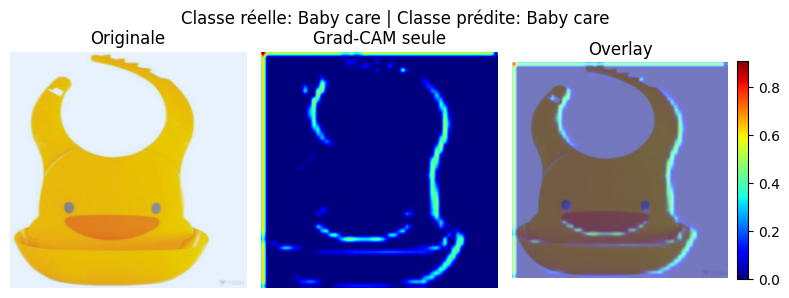

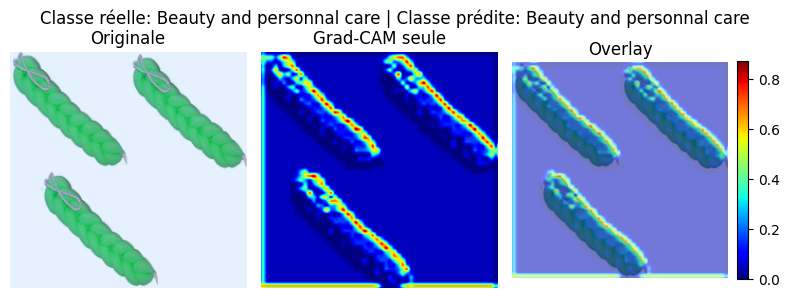

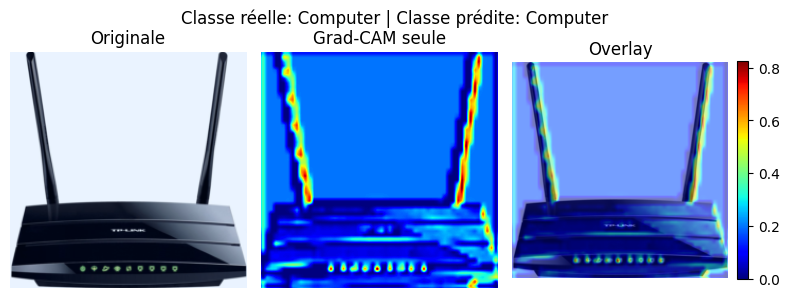

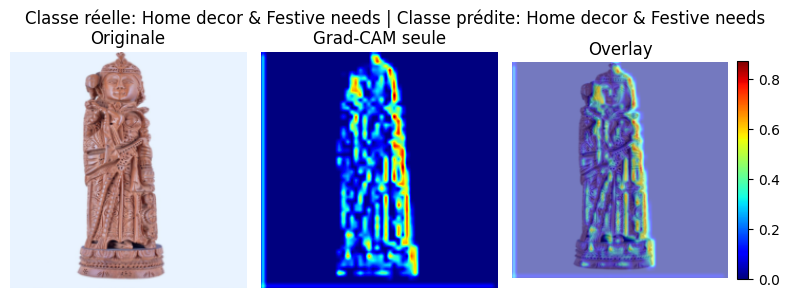

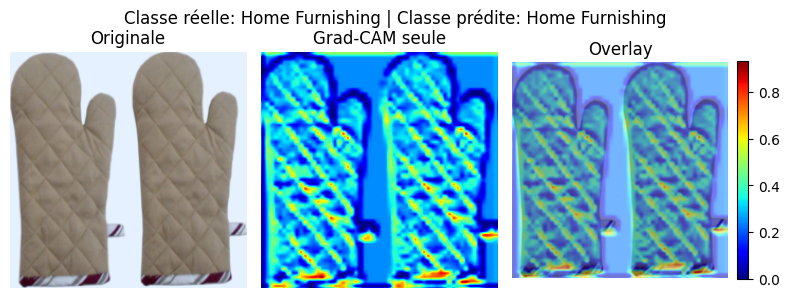

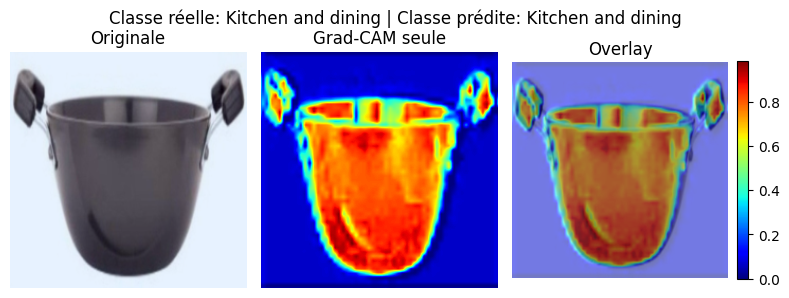

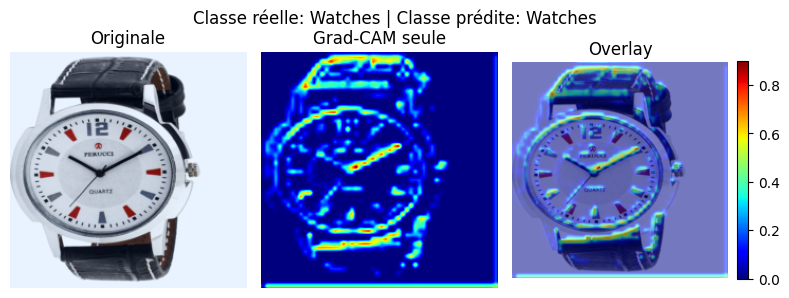

In [11]:
# pour chaque classe
for class_id, class_name in mapping_class.items():
    
    # Obtention des indices de toutes les images de cette classe
    indices = [i for i, (x, y) in enumerate(test_dataset) if y == class_id]
    if len(indices) == 0:
        continue
    
    # Selection d'une image au hasard
    idx = random.choice(indices)
    
    # Extraction de l'image
    img, label = test_dataset[idx]

    # Calcul grad-cam
    cam, pred_class = grad_cam_cvt(model, img, stages=[0], device=device)

    # Conversion de l'image au format numpy et normalisation
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # redimensionnement de CAM
    cam_resized = resize(cam, (img_np.shape[0], img_np.shape[1]), mode='reflect', anti_aliasing=True)
    heatmap = cm.jet(cam_resized)[:,:,:3]

    # Overlapp de la cam et de l'image
    overlay = 0.5*img_np + 0.5*heatmap
    overlay = np.clip(overlay, 0, 1)

    # Construction de la figure
    fig, axes = plt.subplots(1,3, figsize=(8,3))
        
    # Image brute
    axes[0].imshow(img_np)
    axes[0].set_title("Originale")
    axes[0].axis("off")

    # Grad Cam
    im = axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title("Grad-CAM seule")
    axes[1].axis("off")
        
    # Overlap
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04) 
 
    # Ajout d'un titre
    plt.suptitle(f"Classe réelle: {class_name} | Classe prédite: {mapping_class[pred_class]}")
        
    # Ajustement de la figure
    plt.tight_layout()
    
    # Sauvegarde de la figure
    plt.savefig(f'../Output/Explicativité/GradCam.png', format='png')

    # Affichage de la figure
    plt.show()


La méthode d'inteprétation Grad-CAM abouti a des résultats plus facilement interprétables. Contrairement à  l'approche précédente analysant l'importance à l'échelle du pixel, cette méthode met en évidence des zones de l’image présentant des importances élevées et visuellement plus cohérentes. Ces régions concernent soit 
- des formes comme observé pour l'ustensile de cuisine,  
- des contours comme c'est le cas sur l'image du bavoir
- des textures ou reliefs comme sur l'exemple du gant de cuisine et de la figurine 
- des régions plus fine comme certains éléments caractéristiques de la catégorie prédite comme sur l'image représentant la montre. 

Ces régions correspondent aux parties réellement exploitées par le modèle pour prendre sa décision, ce qui permet non seulement de mieux comprendre le fonctionnement interne du modèle, mais aussi de valider que celui ci s’est appuyé sur des caractéristiques pertinentes pour prendre ses décisions plutôt que sur des artefacts visuels.

# Conclusions

Les analyses réalisées dans ce projet avaient pour but d'étudier l'explicatibilité du modèle CvT développé dans le notebook précédent. Deux approches d'interprétabilité ont alors été explorées.

- L'approche SHAP Gradient Explainer, qui fournit une importance au niveau du pixel, mais dont les résultats se sont révélés difficilement exploitables dans ce contexte, en raison du décalage entre l’échelle de l’explication et celle de l’apprentissage du modèle.
- L'approche Grad-CAM, qui s’est distinguée par sa capacité à mettre en évidence des zones cohérentes et visuellement interprétables, permettant de valider que le modèle s’appuie bien sur des caractéristiques pertinentes (contours, textures, détails spécifiques aux catégories) plutôt que sur des artefacts.

Cette démarche montre qu’évaluer un modèle ne doit pas se limiter à mesurer ses performances. Il est également très important de comprendre comment il fonctionne et sur quoi il s’appuie pour prendre ses décisions. Les méthodes d’explication jouent un rôle important car elles permettent de renforcer la confiance qu'on peut avoir dans les résultats obtenus grâce au modèle, de vérifier que le modèle utilise bien des éléments pertinents pour faire ses prédiciton, et pourrait également s'avérer utile pour comprendre plus facilement l'origine de certaines erreurs commises par le modèle.